In [1]:
import sys
sys.path.append('/home/gergedan/WS24/thesis/code')

import numpy as np
import matplotlib.pyplot as plt
import torch

# neural networks
from NN.single_layer_nn import SINGLE_LAYER_NN

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## **1-D Example**
### Here is the first function that we want to approximate 

$$
  f(x) = \frac{x^{3}}{3} - \frac{x^{2}}{2} - \frac{1}{2} \cos{(x^{2})}
$$

$$
  \frac{\partial f(x)}{\partial x} = x^{2} - x + \sin{(x^{2})}x
$$

Where $x \in \mathbb{R}$ and $f(x) \in \mathbb{R}$ 

Drawing function using (100,) points.




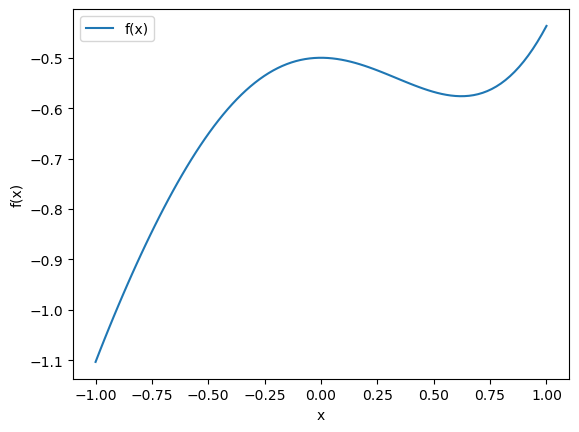

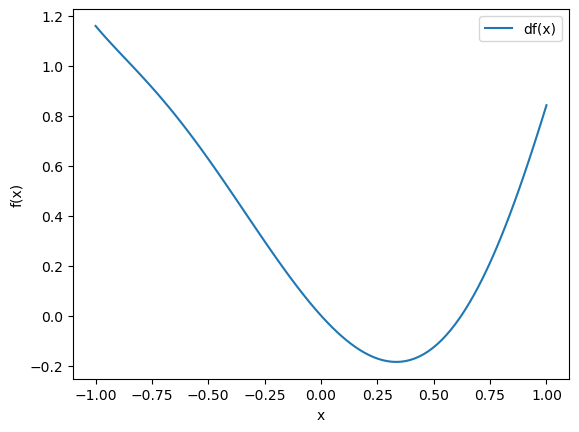

In [3]:
# one dimensional function that we want to approximate as a toy example
def f(x):
    return (x**3)/3 - (x**2)/2 - (1/2)*np.cos(x**2)
def df(x):
    return x**2 - x + np.sin(x**2)*x

N = 100
x = np.linspace(-1, 1, N)
y = f(x)
dx = df(x)

print('Drawing function using', x.shape, 'points.')
fig = plt.figure()
plt.plot(x,y,label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

fig = plt.figure()
plt.plot(x,dx,label='df(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

## **Approximation using Shallow NN**

### If we use a single hidden layer with $M$ neurons with a non-linear activation, which takes the input $x$ and should output $f(x)$ for $x \in \mathbb{R}$. With first layer weights $w^{(1)},b^{(1)} \in \mathbb{R}^M$ and last layer weights $w^{(2)} \in \mathbb{R}^{1 \times M}, b^{(2)} \in \mathbb{R}$ we get the following approximation for a data point $x_i \in \mathbb{R}$ (single feature dimension) $\hat{f}(x_i) = \Phi^{(2)}(x_i) \approx f(x_i)$:

### $$ \Phi^{(0)}(x_i) = x_i \in \mathbb{R}$$

### $$ \Phi^{(1)}(x_i) = \phi(w^{(1)} \Phi^{(0)}(x_i) + b^{(1)}) = \phi(w^{(1)} x_i + b^{(1)}) \in \mathbb{R}^M $$

### $$ \Phi^{(2)}(x_i) = w^{(2)} \Phi^{(1)}(x_1) + b^{(2)} = \bigg( \sum^{M}_{j=1} w^{(2)}_{j} \big( \Phi^{(1)}(x_i) \big)_{j} \bigg) + b^{(2)} = \bigg( \sum^{M}_{j=1} w^{(2)}_{j} \big( \phi(w^{(1)} x_i + b^{(1)}) \big)_{j} \bigg) + b^{(2)} = \hat{f}(x_i) \approx f(x_i) $$

### where $\Phi^{(l)}$ is the output of the $l$-th layer of the network, with a nonlinear activation function $\phi$ in the hidden layer and identity in the output layer. Since we assume we know the derivatives, we can set up the following custom loss function:

### $$ L = w_1 \sum_{j=1}^{K} {\bigg( \frac{\partial \hat{f}(x)}{\partial x}(x_i) - \frac{\partial {f}(x)}{\partial x}(x_i) \bigg)}^{2} + w_2 (\hat{f}(x_0) - f_0)^{2} $$

In [4]:
# redefine on torch
def f(x):
    return (x**3)/3 - (x**2)/2 - (1/2)*torch.cos(x**2)
def df(x):
    return x**2 - x + torch.sin(x**2)*x

In [5]:
def compute_loss(dx_true, dx_preds, f0_true, f0_pred, w1=1, w2=1):
    """
    Computes the above-defined loss function 
    """
    loss_derivative = w1 * torch.sum((dx_preds - dx_true)**2)
    loss_f0 = w2 * (f0_pred - f0_true)**2
    return loss_derivative + loss_f0

param grad required: True
param grad required: True
param grad required: True
param grad required: True
Model structure: SINGLE_LAYER_NN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1, out_features=512, bias=True)
    (2): Tanh()
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)



param grad right after zerograd call: None
param grad right after zerograd call: None
param grad right after zerograd call: None
param grad right after zerograd call: None
param grad right after loss backward: tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
      

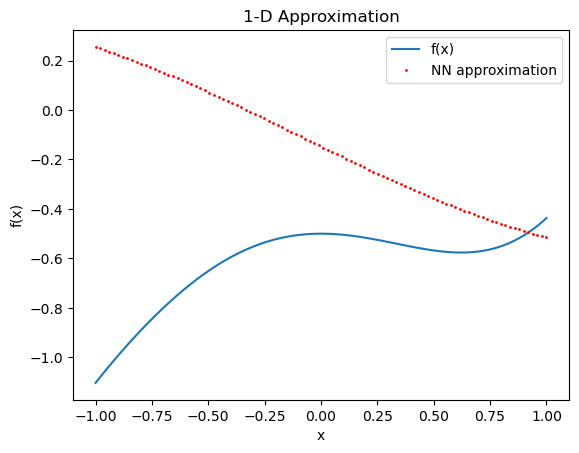

In [6]:
# prepare input of K train points
K = 100
x_train = torch.linspace(-1, 1, K).reshape(K, 1).cuda()
x_train.requires_grad = True # enable gradient tracking for x
dx_true = df(x_train) # true derivatives
fx_train = f(x_train) # function values evaluates at x_train
x0 = torch.tensor([[0.]]).cuda()
f0 = f(x0)
#x_pred = torch.linspace(-10, 1, 1000).reshape(1000, 1)

# prepare model
n_neurons = 512
n_features = 1 # we are approximating a 1D function 
model = SINGLE_LAYER_NN(n_neurons, n_features, activation='tanh')
for param in model.parameters():
    print('param grad required:',param.requires_grad)

model.to(device)
print(f"Model structure: {model}\n\n")
#for name, param in model.named_parameters():
#    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

fig = plt.figure()
ax = plt.gca()
ax.set_title('1-D Approximation')
plt.plot(x,y,label='f(x)')
plt.plot(x_train.detach().cpu().numpy(),model(x_train).detach().cpu().numpy(),'ro',markevery=1,markersize=1,label='NN approximation');
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

# learn
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epoch in range(0, 300):  
    f0_pred = model(x0)     
    
    # perform forward pass 
    optimizer.zero_grad()
    fx_preds = model(x_train)
    if (epoch + 1) % 100 == 0:
        for param in model.parameters():
            print('param grad right after zerograd call:',param.grad)

    # for computing the gradients w.r.t x_train
    #if x_train.grad != None:
        #print('x_train.grad is:',x_train.grad)
        #x_train.grad.zero_()

    #scalar_output = fx_preds.sum() # single scalar is accepted only 
    #dx_preds = torch.autograd.grad(scalar_output, x_train, retain_graph=True)[0]

        
    # compute grads for the parameters 
    loss = compute_loss(dx_true, fx_preds, f0, f0_pred, w1=1, w2=0)
    # Print gradients for debugging
    loss.backward(retain_graph=True)
    if (epoch + 1) % 100 == 0:
        for param in model.parameters():
            print('param grad right after loss backward:',param.grad)
      
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print('Loss after epoch %i: %.3f' % (epoch + 1, loss))

# Process is complete.
print('Training process has finished.')

In [1]:
fig = plt.figure()
ax = plt.gca()
ax.set_title('1-D Approximation')
plt.plot(x,y,label='f(x)')
plt.plot(x_train.detach().cpu().numpy(),model(x_train).detach().cpu().numpy(),'ro',markevery=1, markersize=1, label='NN approximation');
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
print()

NameError: name 'plt' is not defined